[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ninarina12/NX-School-2023/blob/main/AI-ML_Tutorial.ipynb)

# Introduction to AI-ML Applications for X-ray Experiments

## Background
This tutorial describes an introductory-level AI/ML application to assist an experimental workflow inspired by the work of [Starodub *et al*](https://www.nature.com/articles/ncomms2288). In this work, the authors used ultra-short, intense X-ray pulses from an X-ray free-electron laser (FEL) to obtain single-shot diffraction patterns of polystyrene sphere aggregates. These aggregates vary in size from one to multiple spheres and need to be sorted prior to further analysis.

In this tutorial, we will demonstrate how different machine learning techniques can be used to automate and accelerate this type of workflow, including:
- Performing exploratory data analysis using unsupervised learning methods such as principal component analysis (PCA)
- Building a simple convolutional neural network (CNN) to classify synthetic diffraction patterns of sphere aggregates by aggregate size (*i.e.* number of spheres)
- Streamlining the coding process by using ChatGPT to propose code for specific tasks such as generating training data of the target system, building the neural network architecture, and writing a training loop with helpful checkpoints

![background.png](background.png)

### Getting started

#### For Google Colaboratory only (skip these two steps if running a local copy of the notebook):
1. Since we'll be training a neural network, we'll want to have access to a GPU. To do that, go to Runtime > Change runtime type, and select one of the GPU hardware accelerators.

2. We'll also need access to some supporting files from the GitHub repository. Run the code block below to clone the repository and change to the corresponding directory.

In [ ]:
!git clone https://github.com/ninarina12/NX-School-2023.git
%cd NX-School-2023

#### For everyone:
3. Import some helper functions for plotting the results (open `plot_utils.py` in the repository if interested in the details!).

In [1]:
from plot_utils import (plot_object, plot_object_and_pattern, plot_object_grid, plot_pattern_grid,
                        plot_explained_variance, plot_components, plot_inverse_transforms, plot_coefficients,
                        plot_annotated_coefficients, plot_training_history, plot_classification_statistics,
                        plot_confusion_matrix)

## Generation of synthetic objects and diffraction patterns

### Use ChatGPT to make a generator for custom image data

We will use ChatGPT to write a generator for image data resembling the spherical aggregates. For simplicity, we will work in two-dimensions and generate the projection of spherical aggregates on a two-dimensional plane perpendicular to the beam direction.

#### ChatGPT Prompt:
Write a python script using numpy arrays that generates $N \times N$ images with 1-5 randomly-placed circles of a user-provided radius, all of which either touch or overlap one another. Ensure that the first circle is placed within the center $N/2 \times N/2$ pixels of the image.

#### Response:

In [2]:
import numpy as np

def generate_image(N, num_circles, radius):
    if num_circles < 1 or num_circles > 5:
        raise ValueError("Number of circles should be between 1 and 5.")

    # Create an empty NxN image
    image = np.zeros((N, N))

    # Function to generate a circle within an image
    def draw_circle(img, center, rad):
        Y, X = np.ogrid[:img.shape[0], :img.shape[1]]
        dist_from_center = np.sqrt((X - center[0])**2 + (Y - center[1])**2)
        mask = dist_from_center <= rad
        img[mask] = 1

    # Generate the first circle in the center N/2 x N/2 pixels
    center_x = np.random.randint(N/4, 3*N/4)
    center_y = np.random.randint(N/4, 3*N/4)
    centers = [(center_x, center_y)]
    draw_circle(image, centers[0], radius)

    for _ in range(1, num_circles):
        # Randomly select an existing circle
        ref_center = centers[np.random.choice(len(centers))]

        # Generate a random angle to place the new circle
        angle = 2 * np.pi * np.random.rand()

        # Calculate the center of the new circle based on the angle and 2*radius distance
        new_center_x = ref_center[0] + 2 * radius * np.cos(angle)
        new_center_y = ref_center[1] + 2 * radius * np.sin(angle)
        
        # Handle boundaries
        new_center_x = min(max(radius, new_center_x), N - radius)
        new_center_y = min(max(radius, new_center_y), N - radius)

        centers.append((new_center_x, new_center_y))
        draw_circle(image, (new_center_x, new_center_y), radius)

    return image

# Example usage:
N = 128
num_circles = 3
radius = 10
image = generate_image(N, num_circles, radius)

#### Check:
- How are the pixels with overlapping circles labeled? Should we accumulate or overwrite the pixel values?
- Can you explain how the boundaries are handled?

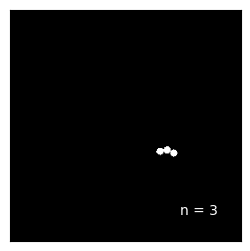

In [3]:
# Generate real-space object
N = 256
num_circles = 3
radius = 4
obj = generate_image(N, num_circles, radius)

# Plot object
fig = plot_object(obj, num_circles)

### Calculate diffraction patterns from generated images
The diffracted intensity $I(\mathbf{q})$ is well-approximated by the square modulus of the Fourier transform of the real-space object $O(\mathbf{r})$ under investigation, i.e.
$$ I(\mathbf{q}) = |F\{O(\mathbf{r})\}|^2,$$
where $F$ denotes the Fourier transform. Thus, we can quickly compute idealized diffraction patterns of our generated images using the `numpy` `fft` library.

Experimental data are also often corrupted by Poisson noise; thus, instead of using the perfect calculated diffraction intensity, we can use it to sample from a Poisson distribution in which the intensity acts as a proxy for the expected event frequency, $\lambda$.

To accomplish this in a systematic way, we will first calculate perfect diffraction patterns and normalize them by the maximum intensity value. Then, we will scale the image by the factor $\lambda_{max}$, the maximum expected event frequency, and resample each pixel from the Poisson distribution with $\lambda$ given by the pixel value. The smaller $\lambda_{max}$ is, the noisier the diffraction pattern will be.

Below, we've pre-written the function to do this:

In [4]:
def calculate_diffraction_pattern(obj, lambda_max=1e3):
    # Calculate the Fourier transform of the object
    ft = np.fft.ifftshift(np.fft.fft2(np.fft.fftshift(obj)))
    
    # Compute the square modulus of the Fourier transform and normalize by the maximum
    diff = np.abs(ft)**2
    diff /= diff.max()
    
    # Scale by the maximum expected event frequency (intensity) and corrupt with poisson noise
    return np.random.poisson(lambda_max*diff)

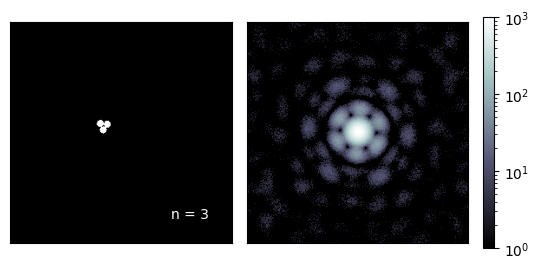

In [5]:
# Generate real-space object
N = 256
num_circles = 3
radius = 4
obj = generate_image(N, num_circles, radius)

# Calculate diffraction pattern
lambda_max = 1e3
diff = calculate_diffraction_pattern(obj, lambda_max)

# Plot object and pattern side-by-side
fig = plot_object_and_pattern(obj, diff, num_circles)

### Generate a large dataset of object images and diffraction patterns
Now we want to construct a large, labeled dataset to be used for machine learning. To do this, we will randomly sample the aggregate size, `num_circles`, at each iteration and then randomly generate the corresponding object and its diffraction pattern. We will also define the class or label of each image as `num_circles - 1` in order to index the classes starting from 0.

In [6]:
from tqdm import tqdm

num_images = 1000
objs = np.zeros((num_images, N, N))
diffs = np.zeros_like(objs)
targets = np.zeros((num_images,), dtype=int)

for i in tqdm(range(num_images), desc="Generating image data"):
    # Randomly select the number of circles to generate
    num_circles = np.random.randint(1,6)
    targets[i] = num_circles - 1
    
    # Generate real-space image
    objs[i] = generate_image(N, num_circles, radius)
    
    # Calculate diffraction pattern
    diffs[i] = calculate_diffraction_pattern(objs[i], lambda_max)

Generating image data: 100%|███████████████| 1000/1000 [00:05<00:00, 196.17it/s]


Visualize a random subset of diffraction patterns from the dataset.

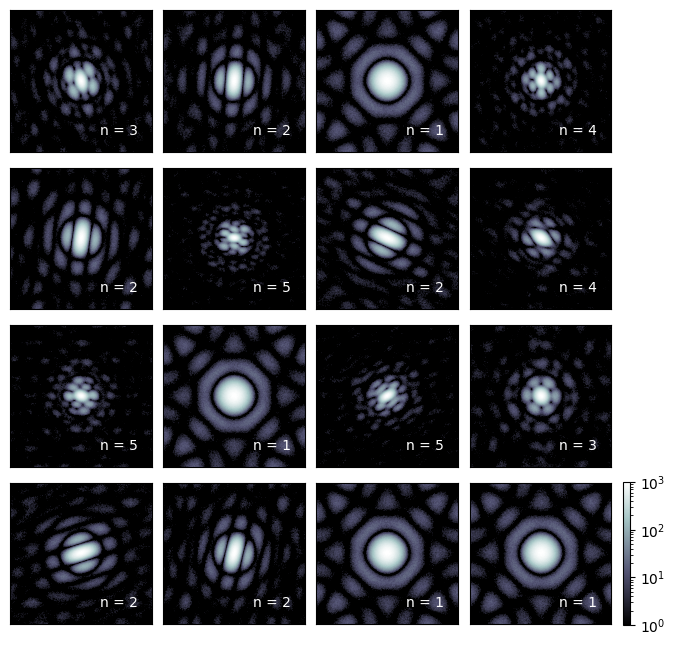

In [7]:
fig = plot_pattern_grid(diffs, targets + 1)

### Questions
1. What patterns do you observe in the diffraction patterns that could be useful for classifying them by the aggregate size?
2. What are some challenges you anticipate in being able to classify these diffraction patterns?

## Exploratory data analysis

Scientific data are complex, and X-ray scattering datasets can be extremely large.  Therefore, exploratory data analysis is an important first step to understanding the structure and distribution of your data. Dimensionality reduction is common first step.

### Use ChatGPT to summarize key concepts of dimensionality reduction

#### ChatGPT Prompt:
Please explain the concept fo dimensionality reduction in three bullet points.

#### Response:
*Certainly! Dimensionality reduction is a technique used to simplify and represent high-dimensional data in a lower-dimensional space while preserving its essential features. Here's a concise explanation in three bullet points:*

***1. High-Dimensional to Low-Dimensional Transformation:**
Dimensionality reduction involves transforming complex data from a high-dimensional space (many features or variables) to a lower-dimensional space (fewer features or variables). This reduction helps simplify data representation, making it easier to visualize, analyze, and interpret.*

***2. Retaining Relevant Information:**
During dimensionality reduction, the goal is to retain as much meaningful information as possible while discarding or compressing less important or redundant features. This is achieved by identifying patterns, relationships, and correlations among the original features.*

***3. Applications and Benefits:**
Dimensionality reduction is widely used in various fields, such as machine learning, data visualization, and feature engineering. It can lead to faster computations, reduced memory requirements, and improved model performance by mitigating the "curse of dimensionality," where data becomes sparse and models become complex in high dimensions. Popular techniques include Principal Component Analysis (PCA), t-Distributed Stochastic Neighbor Embedding (t-SNE), and autoencoders.*

*In summary, dimensionality reduction simplifies data by transforming it into a lower-dimensional space while retaining crucial information, enabling better understanding, analysis, and modeling of complex datasets.*



We can start by decomposing the sythetic diffraction dataset using PCA to observe any inital trends.

In [8]:
from sklearn.decomposition import PCA

# Initiate PCA model with many components
pca = PCA(n_components=16)

# Flatten diffraction data from N x N images to vectors of length N^2
diffs_vector = diffs.reshape(num_images, N*N) 

# Fit PCA model to diffraction data
# This will be a M x n_components matrix where each row corresponds to the transform of a single diffraction pattern
# and the columns correspond to coefficients of each principal component
pca_transform = pca.fit_transform(diffs_vector) 

Each principal component of a dataset explains some amount of the variance in the dataset.  The components are ordered based on their explained variance ratio, such that the first component explains the largest amount of the dataset, and the last component number explains the least variance.

The explained variance ratio can be plotted as a function of component number to understand how many components are needed to accurately represent the dataset. Highly structured datasets can be described by a small number of components. In these cases, the last several components primarily capture noise in the data.

In the following plot we see that the first 3 components describe the majority of the variance.

Explained variance of first 3 components: 89.10%


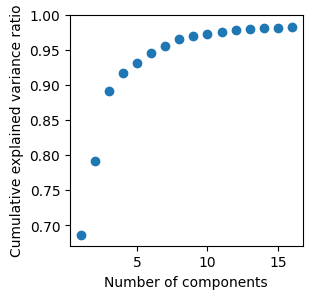

In [9]:
fig = plot_explained_variance(pca)

We can now visualize the principal components to understand what types of variation are present in the data set

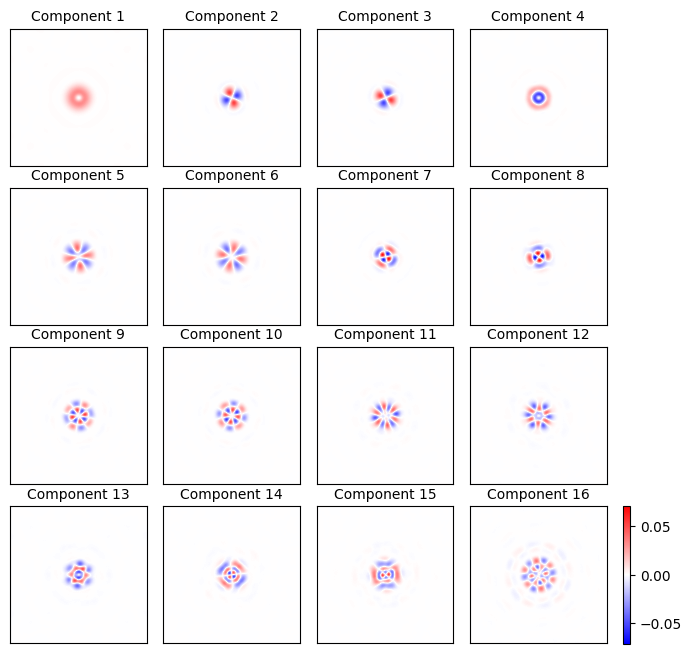

In [10]:
fig = plot_components(pca)

### Questions
1. How does the symmetry of the components plotted above change with component number?
2. Even though our aggregates are not crystalline, on average the rotational symmetry of the diffraction pattern corresponds with the number of particles in the aggregate.  Our dataset is balanced, meaning that we see equal amounts of diffraction patterns for all aggregate sizes; however, PCA explained variance shows that the data is weight heavily towards components 1-3 which only show circular and 2-fold rotational symmetry.  Does this indicate any bias in the dataset?  Does this have any implications for our ability to classify more complex diffraction patterns in the future?
  
<br />
<br />
  
Inverting the PCA decomposition to reconstruct the original data can help us visualize the quality of the reduced representation.  PCA can provide an exact reconstruction of the data given an infinite number of components; however, in practice we want to use a few components as possible to get the simplest explanation of the data.

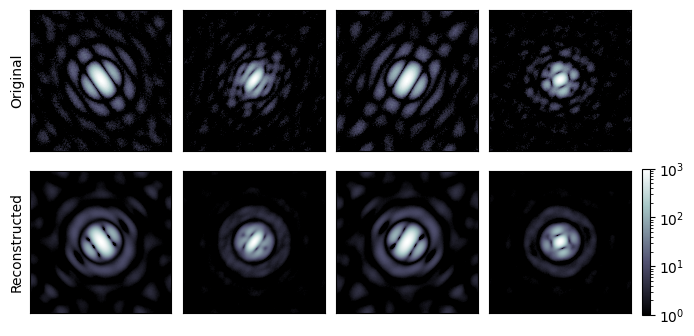

In [11]:
pca_inverse = pca.inverse_transform(pca_transform)
fig = plot_inverse_transforms(pca_inverse, diffs)

### Questions
Redo the PCA decomposition with fewer components (for example 3 or 4).  
1. What happens to the reconstructions?  
2. How do these compare to the reconstructions with more components? To the original diffraction data?


### Visualize the data representation in principal component space
Now that we've visualized the principal components and found that they correspond to specific features of the diffraction data, we can also plot the principal component coefficients for the whole dataset to see if any trends appear.

Below, we plot the first and second component coefficient for each datapoint and color the points by the number of particles in the image. We can see that the data corresponding to a single particle appear as a single dense point far away from the rest of the data. This makes sense, since all scattering patterns from single particles should be identical with spherical symmetry. Images with two particles appear as a sharp vertical line, and data with increasing particle numbers appear as more diffuse lines.

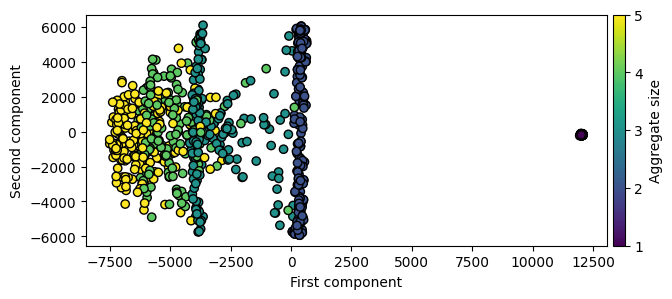

In [12]:
fig = plot_coefficients(pca_transform, targets)

We can also visualize how the data vary as a function of the first two principal components by plotting a few example diffraction patterns.

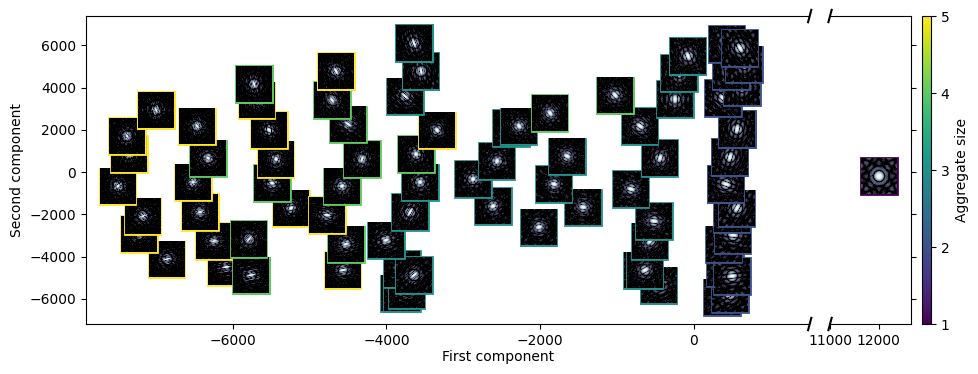

In [16]:
fig = plot_annotated_coefficients(pca_transform, diffs, targets, x_right=1500, x_left=11000)

### Questions
1. How can we interpret the fact that diffraction data appear as vertical lines in this reduced space, especially for small aggregate sizes?
2. What does it mean that we see data shift toward low values of the first component as aggregate size increases?
3. Based on our understanding of the data distribution, what issues can we expect for classifying the data?

## Image classification with convolutional neural networks (CNNs)

### Use ChatGPT to build a simple CNN classifier
We will use the `PyTorch` library to build and train a neural network classifier. Let's use ChatGPT to recommend a neural network architecture for classifying the diffraction patterns into one of five classes.

#### ChatGPT Prompt:
Make a neural network model in PyTorch that classifies $N \times N$ grayscale images into 5 classes.

#### Response:

In [17]:
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self, N):
        super(SimpleCNN, self).__init__()

        # Assuming grayscale image so input channels = 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(in_features=64 * (N//4) * (N//4), out_features=128)  # after two max-pooling layers
        self.fc2 = nn.Linear(in_features=128, out_features=5)  # 5 classes
        
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.maxpool(x)

        x = self.relu(self.conv2(x))
        x = self.maxpool(x)

        x = x.view(x.size(0), -1)  # flatten the tensor
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x
    
# Example of usage:
model = SimpleCNN(N=128)
print(model)

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=65536, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=5, bias=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
)


#### Check:
- Does the model have the correct number of input and output dimensions? Note that the example uses $N=128$.
- What hyperparameter choices were made that might require tuning (*e.g.* number of neurons in a given layer)?

### Use ChatGPT to prepare data for training

#### ChatGPT Prompt:
How should I format data originally in the form of numpy arrays that would be used to train the CNN?

#### Response:
1. **Convert Numpy Arrays to PyTorch Tensors:** Use `torch.from_numpy()` to convert numpy arrays to PyTorch tensors.

2. **Normalize Data:** It's a good practice to normalize your image data to have values between [0, 1] or [-1, 1], or to have a mean of 0 and a standard deviation of 1, depending on the use case.

3. **Channel Dimension:** PyTorch expects data in the format (batch_size, channels, height, width). Ensure your data is correctly shaped. If you have grayscale images, you need to add an additional channel dimension.

4. **Dataset and DataLoader:** Create a custom dataset by subclassing `torch.utils.data.Dataset`. Then, use `DataLoader` for batching, shuffling, and parallelizing the data loading.

In [18]:
from torch.utils.data import Dataset, DataLoader

# Sample numpy data
# Assuming X_train and y_train are your image and label numpy arrays respectively
# X_train shape: (num_samples, height, width)
# y_train shape: (num_samples, )

class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]
        
        # Add channel dimension for grayscale image
        img = img[np.newaxis, :, :]

        # Convert image from numpy array to PyTorch tensor
        img = torch.from_numpy(img).float()

        if self.transform:
            img = self.transform(img)
        
        return img, label

# Create dataset and dataloader
# dataset = CustomDataset(X_train, y_train)
# train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

Let's format our numpy arrays into a dataset using the code above:

In [19]:
# Defining the dataset using our variable names
dataset = CustomDataset(diffs, targets)

Since we don't have our data divided into training, validation, and testing sets as ChatGPT expects, let's ask it to perform a random split of the data before defining the `DataLoader`.

#### ChatGPT Prompt:
Assuming I have a CustomDataset called 'dataset' of all my data, can you split it into training, validation, and test sets and define separate Dataloaders for each?

#### Response:

In [44]:
from torch.utils.data import DataLoader, random_split

# Assuming dataset is already defined
# dataset = CustomDataset(...)

# Define the proportion of the splits
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

# Note: Defining test_ratio as above can lead to issues at the assertion statement due to numerical precision.
#       We can tweak ChatGPT's suggestion to the following in order to avoid an AssertionError.
test_ratio = 1 - train_ratio - val_ratio

# Make sure the ratios sum to 1
assert train_ratio + val_ratio + test_ratio == 1, "Ratios must sum to 1!"

# Calculate the number of samples in each split
total_size = len(dataset)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size

# Use random_split to split the dataset into respective subsets
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Define DataLoaders for each subset
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Use ChatGPT to write a training loop for the CNN
Let's use ChatGPT to recommend the training protocol for the CNN; for example, what loss function, optimizer, learning rate, and number of iterations (epochs) to use as a starting point. We can also ask for the loss to be recorded after each epoch in order to inspect the training history.

#### ChatGPT Prompt:
Write the training loop to optimize the SimpleCNN defined before, assuming N is given, which displays a progress bar and prints the current accuracy on the training and validation datasets for each epoch. Also save the training and validation losses and accuracies at each epoch to lists.

#### Response:

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SimpleCNN(N).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [35]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    # Training loop with progress bar using tqdm
    for inputs, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        
    train_accuracy = correct_train / total_train
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    val_accuracy = val_correct / val_total
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]:.3f},",
          f"Training Accuracy: {train_accuracy*100:.2f}%, Validation Loss: {val_losses[-1]:.3f},",
          f"Validation Accuracy: {val_accuracy*100:.2f}%")

print("Finished Training.")
#print("Training Losses:", train_losses)
#print("Training Accuracies:", train_accuracies)
#print("Validation Losses:", val_losses)
#print("Validation Accuracies:", val_accuracies)

Validation Epoch 1/10: 100%|█████████████████████| 7/7 [00:00<00:00, 135.64it/s]


Epoch 1/10, Training Loss: 18.490, Training Accuracy: 40.43%, Validation Loss: 1.400, Validation Accuracy: 54.50%


Validation Epoch 2/10: 100%|█████████████████████| 7/7 [00:00<00:00, 133.00it/s]


Epoch 2/10, Training Loss: 1.222, Training Accuracy: 58.29%, Validation Loss: 0.798, Validation Accuracy: 67.00%


Validation Epoch 3/10: 100%|█████████████████████| 7/7 [00:00<00:00, 132.93it/s]


Epoch 3/10, Training Loss: 0.789, Training Accuracy: 66.43%, Validation Loss: 0.568, Validation Accuracy: 70.50%


Validation Epoch 4/10: 100%|█████████████████████| 7/7 [00:00<00:00, 139.34it/s]


Epoch 4/10, Training Loss: 0.669, Training Accuracy: 68.86%, Validation Loss: 0.418, Validation Accuracy: 86.00%


Validation Epoch 5/10: 100%|█████████████████████| 7/7 [00:00<00:00, 139.05it/s]


Epoch 5/10, Training Loss: 0.558, Training Accuracy: 75.00%, Validation Loss: 0.369, Validation Accuracy: 84.50%


Validation Epoch 6/10: 100%|█████████████████████| 7/7 [00:00<00:00, 139.28it/s]


Epoch 6/10, Training Loss: 0.451, Training Accuracy: 80.86%, Validation Loss: 0.361, Validation Accuracy: 85.50%


Validation Epoch 7/10: 100%|█████████████████████| 7/7 [00:00<00:00, 138.54it/s]


Epoch 7/10, Training Loss: 0.448, Training Accuracy: 80.29%, Validation Loss: 0.303, Validation Accuracy: 90.00%


Validation Epoch 8/10: 100%|█████████████████████| 7/7 [00:00<00:00, 138.76it/s]


Epoch 8/10, Training Loss: 0.379, Training Accuracy: 83.86%, Validation Loss: 0.295, Validation Accuracy: 89.50%


Validation Epoch 9/10: 100%|█████████████████████| 7/7 [00:00<00:00, 138.84it/s]


Epoch 9/10, Training Loss: 0.330, Training Accuracy: 87.57%, Validation Loss: 0.288, Validation Accuracy: 90.50%


Validation Epoch 10/10: 100%|████████████████████| 7/7 [00:00<00:00, 138.48it/s]

Epoch 10/10, Training Loss: 0.281, Training Accuracy: 87.71%, Validation Loss: 0.367, Validation Accuracy: 86.00%
Finished Training.


### Evaluate the trained model

The first assessment we can make is whether the model is under- or overfit to the training data. We can start by plotting the evolution of the training and validation loss and accuracy over the course of training. A good stopping point to avoid overfitting is when the validation loss stops decreasing.

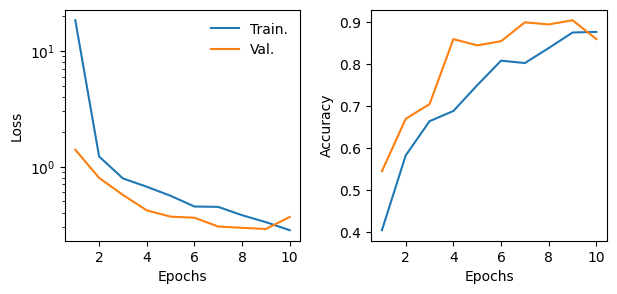

In [36]:
fig = plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies)

Notice that ChatGPT selected the cross-entropy loss criterion to optimize the CNN. This is a common choice for classification problems, and is defined on each data point as,
$$ L_{CE} = -\sum_{i=1}^{n}t_i \log{p_i},$$
where $n$ is the total number of classes, $t_i$ gives the true class (*i.e.* is equal to 1 when $i$ is the true class and zero otherwise), and $p_i$ is the softmax probability for the $i^{th}$ class predicted by the neural network.

**Note:** `PyTorch` defines its cross-entropy loss between the target and predicted *logits* as opposed to softmax probabilities. This means that to obtain the probabilities associated with the outputs of our neural network, we need to apply the softmax function to the ouputs ourselves.

Let's ask ChatGPT to evaluate the CNN on the held-out testing dataset and inspect both the predicted classes and associated probabilities for each data point.

#### ChatGPT Prompt:
Please evaluate the model on the entire test dataset, and save both the predicted class label and the probability of the predicted class to arrays. Also make a corresponding array of the true class labels that would allow them to be compared easily.

#### Response:

In [45]:
model.eval()

# Initialize lists to store results
all_predictions = []
all_probabilities = []
all_true_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        
        outputs = model(inputs)
        
        # Softmax to get probabilities
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        
        _, predicted = torch.max(outputs.data, 1)
        
        all_predictions.extend(predicted.cpu().numpy())
        
        # Get the probability of the predicted class
        all_probabilities.extend(probabilities[range(len(predicted)), predicted].cpu().numpy())
        
        all_true_labels.extend(labels.cpu().numpy())

# Convert lists to numpy arrays
all_predictions = np.array(all_predictions)
all_probabilities = np.array(all_probabilities)
all_true_labels = np.array(all_true_labels)

#print("Predictions:", all_predictions)
#print("Probabilities:", all_probabilities)
#print("True Labels:", all_true_labels)

Let's compare the predicted probabilities for correctly and incorrectly classified examples.

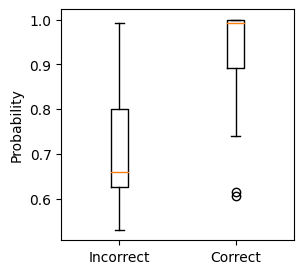

In [47]:
# Define indicators for the correctly and incorrectly classified examples
correct = all_predictions == all_true_labels
incorrect = all_predictions != all_true_labels

# Make a boxplot of predicted probabilities for correctly and incorrectly classified examples
fig = plot_classification_statistics(all_probabilities, incorrect, correct)

Another helpful assessment tool is the confusion matrix, which can be directly calculated using the `scikit-learn` library and the arrays we've constructed. Each entry $C_{i,j}$ of the confusion matrix gives the number of examples belonging to class $i$ that are classified as $j$.

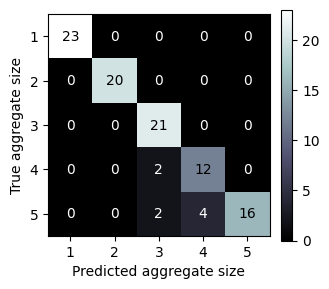

In [48]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(all_true_labels, all_predictions, labels=range(5))
fig = plot_confusion_matrix(cm)

Finally, we can also plot the images of the underlying objects to visualize which configurations were most difficult to classify.

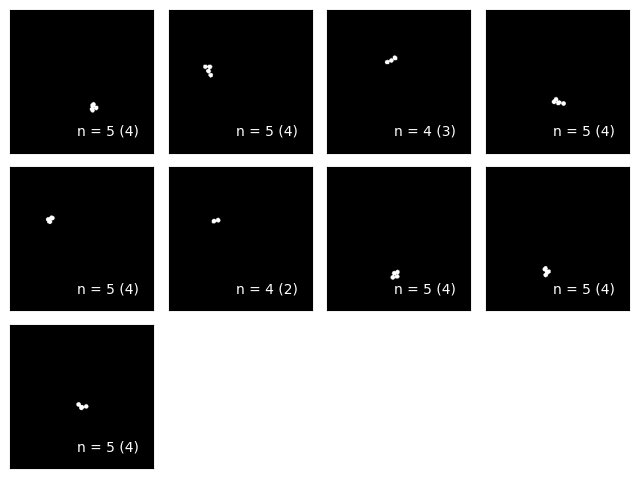

In [43]:
# Plot a grid of examples with labels denoting the true (predicted) aggregate size
labels = [str(i) + ' (' + str(j) + ')' for (i,j) in zip(test_targets[incorrect] + 1, test_predictions[incorrect] + 1)]
fig = plot_object_grid(test_objs[incorrect], labels)

### Questions
1. How do modifications to the model architecture affect performance, *e.g.* changing the dropout rate, including additional convolution and pooling layers?
2. The neural network weights are randomly initialized before training; how do different initializations affect the performance?
3. How might you filter predictions that are more likely to be incorrectly classified?
4. The bigger the aggregate size, the more variations we can observe in the diffraction patterns due to reduced rotational symmetry. What are some strategies to account for this imbalance between the different class labels?
5. How does the amount of simulated noise affect the classification accuracy?